In [11]:
import os
import openai
import numpy as np
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
from pymilvus import Collection, CollectionSchema, FieldSchema, DataType, connections
from pymilvus import connections, utility
from langchain_openai import OpenAIEmbeddings
from langchain import text_splitter 
from langchain_community.vectorstores import Milvus
from langchain_community.retrievers.milvus import MilvusRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import AutoTokenizer, AutoModel

# 실험환경

In [2]:
# 임베딩 모델이름
company = 'OPENAI'
embedding_models = 'text-embedding-3-large'
header_include = True
table_include = True
split_yn = False
documnet_name = "2024 IONIQ5"

In [3]:
exp_name = f"{company}_{embedding_models}_h{header_include}_t{table_include}_s{split_yn}"
exp_dir = '../result/' + exp_name

os.makedirs(exp_dir, exist_ok=True)

In [4]:
DOC_DATA_DIR = '../../../pdf_parsing/parse_result/'
DOC_DATA_PATH =  DOC_DATA_DIR + 'doc_ioniq5_result.parquet'
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

tqdm.pandas()

In [6]:
df = pd.read_parquet(DOC_DATA_PATH)

## 문장 길이

<Axes: ylabel='Frequency'>

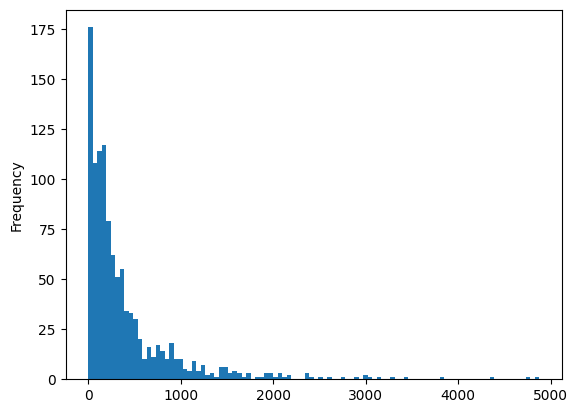

In [11]:
df['doc_table_contents'].apply(lambda x: len(x)).plot.hist(bins=100)

# Embedding

In [7]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [13]:
global tokens

tokens=0


def get_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text
    )
    global tokens
    tokens = tokens + response.usage.total_tokens
    # print(index)
    return response.data[0].embedding

In [9]:
df['doc_table_contents'] = \
    "설명서 대제목:" + df['h1'] + '\n' + \
    "설명서 중제목:" + df['h2'].fillna('') + '\n' +\
    "설명서 소제목:" + df['h3'].fillna('') + '\n' + \
    df['doc_table_contents']

In [28]:
embedding_result = df['doc_table_contents'].progress_apply(lambda x: get_embedding(x))

100%|██████████| 1089/1089 [08:49<00:00,  2.06it/s]


In [31]:
print(f"TOKEN USAGE: {tokens}")
print(f"PRICE USAGE: {(tokens/1024/1024)*0.02*1300}원")

TOKEN USAGE: 458270
PRICE USAGE: 11.363048553466797원


In [32]:
df['embeddings'] = embedding_result

## Embedding 결과 저장

In [34]:
embedding_result_path = exp_dir + '/embeddings.parquet'
df.to_parquet(embedding_result_path, index=False)

# Vector DB 저장

In [5]:
MILVUS_HOST = os.environ['MILVUS_HOST']
MILVUS_PORT = os.environ['MILVUS_PORT']
COLLECTION_NAME = "ioniq5_2024_manual"
connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT)

In [14]:
embedding_result_path = exp_dir + '/embeddings.parquet'
df = pd.read_parquet(embedding_result_path)

## Document 내 header 제외

**내용이 없기 때문**

In [15]:
df = df[df['h1']!=df['doc_contents']]
df = df[df['h2']!=df['doc_contents']]
df = df[df['h3']!=df['doc_contents']]

In [16]:
df['car_type'] = documnet_name

**Collection 삭제 예시**

In [9]:
# utility.drop_collection("ioniq5_2024_manual")

## Collection 생성

In [12]:
id_field = FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False)
car_type_filed = FieldSchema(name="car_type", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='차종')
major_h_filed = FieldSchema(name="majorheading", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='설명서의 대제목')
sub_h_filed = FieldSchema(name="subheadings", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                         description='설명서의 중제목')
minor_h_filed = FieldSchema(name="minorheading", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='설명서의 소제목')
contents_filed = FieldSchema(name="contents", dtype=DataType.VARCHAR, max_length=20000, is_primary=False, auto_id=False,
                            description='설명서의 내용')
imgurl_filed = FieldSchema(name="img_url", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=20, max_length=50,
                            description='이미지 URL 경로')
tblimgurl_field = FieldSchema(name="tbl_img_url", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=20, max_length=50,
                            description='표 이미지 URL 경로')
tbl_contents_filed = FieldSchema(name="tbl_contents", dtype=DataType.VARCHAR, max_length=10000, is_primary=False, auto_id=False,
                            description='표 내용')
page_filed = FieldSchema(name="block_nums", dtype=DataType.VARCHAR, max_length=7, is_primary=False, auto_id=False,
                            description='page번호')
vector_filed = FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=3072)
# 컬렉션 스키마 정의
schema = CollectionSchema(
    fields=[
        id_field, 
        car_type_filed,
        major_h_filed,
        sub_h_filed,
        minor_h_filed,
        contents_filed,
        imgurl_filed,
        tblimgurl_field,
        tbl_contents_filed,
        page_filed,
        vector_filed],
    description="2024 아이오닉5 문서"
)

# 컬렉션 생성
if COLLECTION_NAME not in utility.list_collections():
    collection = Collection(name=COLLECTION_NAME, schema=schema)
else:
    collection = Collection(name=COLLECTION_NAME)


## Data 적재

In [13]:
#Index 생성
df = df.reset_index(drop=True).reset_index()

#NaN 처리
df[['table_contents']] = df[['table_contents']].fillna('')
df['img_urls'] = df['img_urls'].apply(lambda d: d.tolist() if d is not None else [])
df['table_img_urls'] = df['table_img_urls'].apply(lambda d: d.tolist() if d is not None else [])

# Pandas DataFrame에서 데이터 추출 및 Milvus에 삽입
ids = df['level_0'].to_list()
car_types = df['car_type'].to_list()
h1s = df['h1'].to_list()
h2s = df['h2'].fillna('').astype(str).to_list()
h3s = df['h3'].fillna('').astype(str).to_list()
cons = df['doc_table_contents'].to_list()
img_urls = df['img_urls'].to_list()
table_img_urls = df['table_img_urls'].to_list()
table_contents = df['table_contents'].to_list()
blocks = df['block_num'].to_list()
vectors = df['embeddings'].to_list()

In [ ]:
if COLLECTION_NAME not in utility.list_collections():
    mr = collection.insert([ids, car_types, h1s, h2s, h3s, cons, img_urls, table_img_urls, table_contents, blocks, vectors])

## Index 생성

In [ ]:
collection.create_index(
    field_name="vector", 
    index_params={
        "index_type": "IVF_FLAT", 
        "metric_type": "COSINE", 
        "params": {"nlist": df['h2'].nunique()} # Cluster 개수
        }
)

# 실험